# 0.Introduction

- Name: Vo Pham Tuan Dung
- Student ID: 2010013
- Dataset: HAR (Human Action Recognition)
- Model: CLIP
- My works in this notebook:
    - Apply CLIP for classification by considering each label as small text prompt (Ex: "sitting down" -> "a photo of a person who is sitting down")
    - Re-implement the Trainer class (inspired by Keras, Huggingface)

In [ ]:
%%capture
%pip install --upgrade pip
%pip install datasets transformers evaluate omegaconf
%pip install bitsandbytes accelerate wandb

In [ ]:
#Import packages
# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import evaluate
# from transformers import TrainingArguments, Trainer
from transformers.trainer_utils import get_last_checkpoint
import bitsandbytes as bnb

# visualization, data utils
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import datasets
from PIL import Image
from datasets import load_dataset
from torch.utils.data import DataLoader
import wandb


# evaluation
import evaluate, sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# other utils
from tqdm import tqdm
from functools import partial
import os, glob, sys, shutil, datetime
from pathlib import Path
import random, math
from tqdm import tqdm
from dataclasses import dataclass
from typing import Any, Dict, Tuple, Union, List, Optional, Callable
from omegaconf import DictConfig, OmegaConf
import gc

# define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
# CLIP MODEL from HuggingFace
from transformers import (CLIPImageProcessor, CLIPModel, CLIPProcessor,
                          CLIPTokenizerFast, Trainer, TrainingArguments)
from transformers.tokenization_utils_base import BatchEncoding

# 1.Data Preparation

## 1.1.Download dataset

**Origin Source**: https://aiplanet.com/challenges/233/data-sprint-76-human-activity-recognition-233/overview/about (Data Sprint 76 - Human Activity Recognition Challenge)

**HuggingFace-Datasets Source**: https://huggingface.co/datasets/Bingsu/Human_Action_Recognition

**Task**: *Human Action Recognition* (classfication task)

In [ ]:
dataset = load_dataset('Bingsu/Human_Action_Recognition')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


- Dataset has been divided into train and test set:
    - The train split has **12600** pairs of (image, label).
    - The test split has **5400** pairs of (image). The labels for test set hasn't published yet by the challenge organizer.

- For this notebook, I discard the origin test set. I will divide the original train set into 3 splits: train, validation and test.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 5400
    })
})

In [ ]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=240x160>,
 'labels': 11}

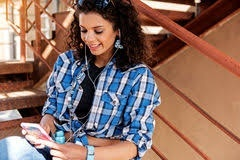

In [ ]:
dataset['train'][0]['image']

## 1.2.Class-Label mappings
- Get from https://huggingface.co/datasets/Bingsu/Human_Action_Recognition
- There are total 15 classes in dataset

In [ ]:
STRING2ID = {
    'calling': 0,
    'clapping': 1,
    'cycling': 2,
    'dancing': 3,
    'drinking': 4,
    'eating': 5,
    'fighting': 6,
    'hugging': 7,
    'laughing': 8,
    'listening_to_music': 9,
    'running': 10,
    'sitting': 11,
    'sleeping': 12,
    'texting': 13,
    'using_laptop': 14
}
ID2STRING = {v: k for k, v in STRING2ID.items()}
CLASS_NAMES = list(STRING2ID.keys())
CLASS_IDS = dataset['train'].unique('labels')
print(len(CLASS_IDS))

15


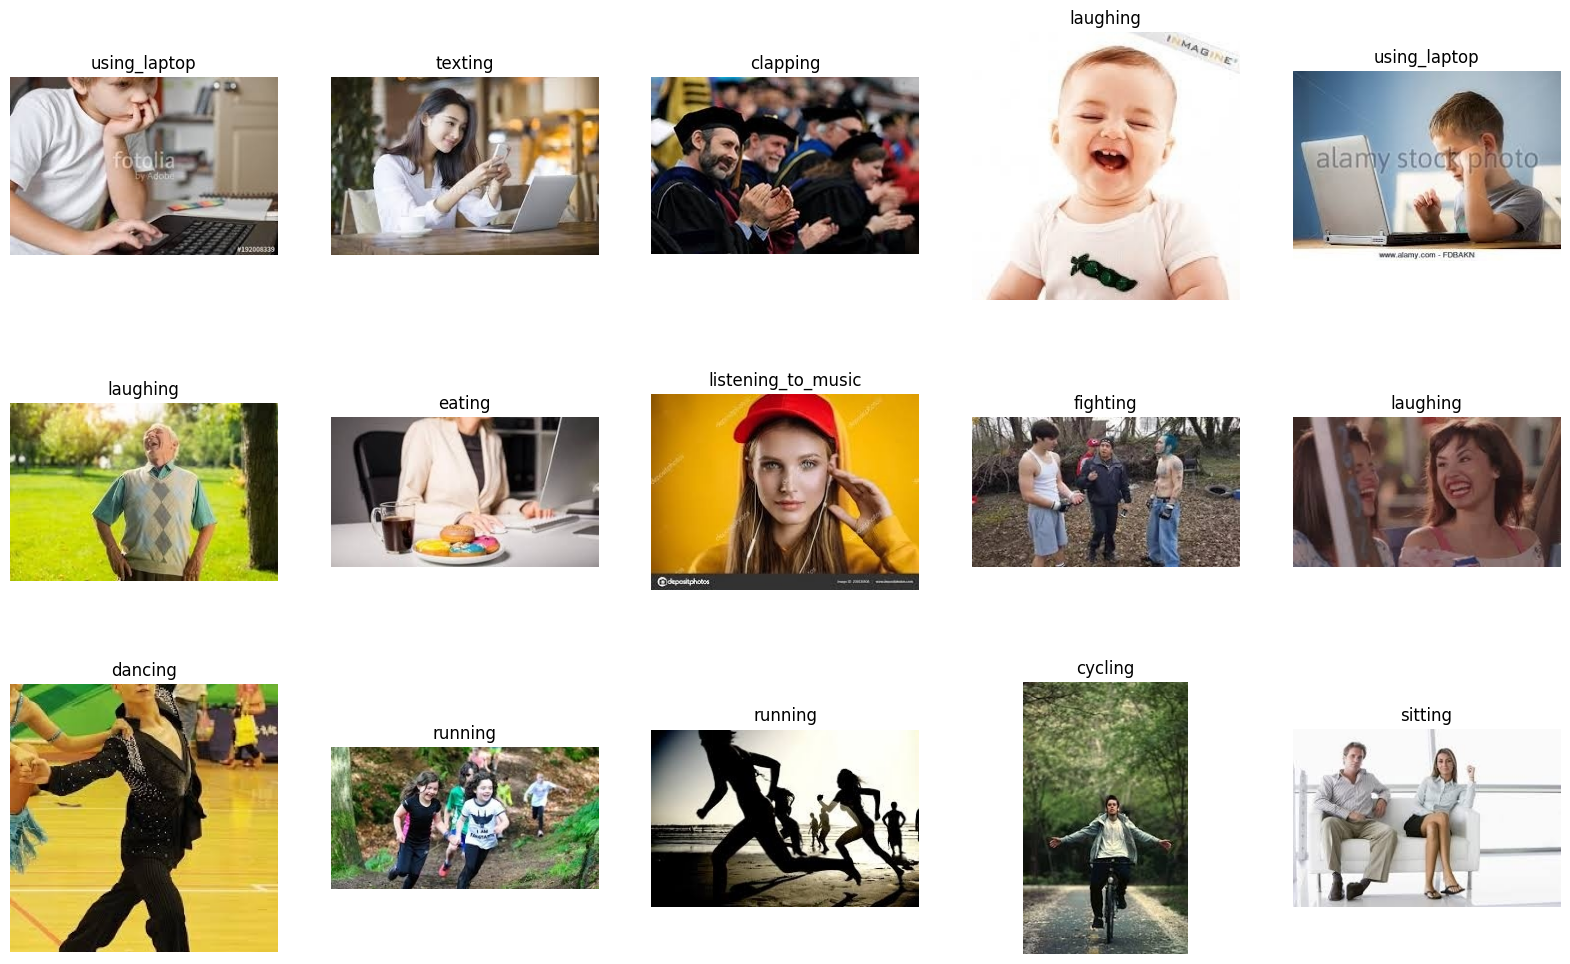

In [ ]:
def show_samples(ds,rows=3,cols=5):
    samples = ds.shuffle().select(np.arange(rows*cols))
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['labels'] # id
        label = ID2STRING[label]
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

## 1.3.Class distribution visualization

In [ ]:
WHOLE_CLASS_COUNT = {}
for label in dataset['train']['labels']:
    if label not in WHOLE_CLASS_COUNT:
        WHOLE_CLASS_COUNT[label] = 0
    WHOLE_CLASS_COUNT[label] += 1
WHOLE_CLASS_COUNT
CLASS_DIST = {k:v/len(dataset['train']) for k,v in WHOLE_CLASS_COUNT.items()}

fig = px.pie(names=CLASS_NAMES, values=CLASS_DIST, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()
fig = px.bar(x=CLASS_NAMES,y=CLASS_DIST,title='Class Frequency')
fig.update_layout({'title':{"x":0.1}})
fig.show()
order=[i for i,y in sorted(WHOLE_CLASS_COUNT.items(),key=lambda kv:(kv[1],kv[0]))]

***- The dataset is balanced !***

## 1.4.Dataset splitting

- Divide the original train dataset into 3 paritions: train, val and test with 60%, 15% and 25% respectively.
- The original test set will be discarded due to the lack of labels.

In [ ]:
train_ratio, val_ratio, test_ratio = 0.6, 0.15, 0.25


def split_dataset(dataset, val_ratio, test_ratio):
    first_split_dataset = dataset['train'].train_test_split(
        test_size=val_ratio+test_ratio,
        seed=42,
        stratify_by_column='labels'
    )
    second_split_dataset = first_split_dataset['test'].train_test_split(
        test_size=test_ratio/(test_ratio+val_ratio),
        seed=42,
        stratify_by_column='labels'
    )

    train_dataset = first_split_dataset['train']
    val_dataset = second_split_dataset['train']
    test_dataset = second_split_dataset['test']
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset, val_ratio, test_ratio)

In [ ]:
final_dataset = datasets.DatasetDict({
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
})
final_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 7560
    })
    val: Dataset({
        features: ['image', 'labels'],
        num_rows: 1890
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 3150
    })
})

My final train, validation and test set contain 7560, 1890, 3150 images respectively.

# 2.Define Image-to-Label Retriever based on CLIP




My CLIP based classification model will work as follows:
1. **Prompt Generation**: Initial prompts are generated based on the labels present in the dataset.
2. **Prompt Feature Extraction**: Features are extracted from these prompts using CLIP 's text encoder.
3. **Visual Feature Extraction**: For each image, features are extracted using CLIP 's image encoder.
4. **Similarity Score Computation**: A similarity score between the image and the set of prompts is computed.
5. **Prediction Based on Similarity**: The most similar prompt is selected, and its associated label is used as the final prediction for the image.

For training:
- Given a batch of N images, the model calculate the similarity score between each image and each prompt, then scale by the logit scale parameter, then apply softmax.

For inference:
- The label corresponding to the prompt having the highest similarity score with image is considered as the model 's prediction.




In [ ]:
MODEL_NAME = "openai/clip-vit-base-patch16"
TOKENIZER = CLIPTokenizerFast.from_pretrained(MODEL_NAME)
IMAGE_PROCESSOR = CLIPImageProcessor.from_pretrained(MODEL_NAME)

PROMPT = "a photo of person/people who is/are {label}"

## 2.1.Auxilary function

In [ ]:
# utilities functions
def get_module_device(module):
    return next(module.parameters()).device

def freeze_params(module, freeze_top_percent=1.0):
    all_params_length = len(list(module.parameters()))
    for indx, param in enumerate(module.parameters()):
        if int(all_params_length * freeze_top_percent) <= indx:
            break
        param.requires_grad = False

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable params: {(trainable_params / 10**6):.4f}M || All params: {(all_param / 10**6):.4f}M || Trainable%: {100 * trainable_params / all_param:.2f}%"
    )

## 2.2 Classifier

In [ ]:
class CLIPLabelRetriever(nn.Module):
    def __init__(self, clip_model: CLIPModel, tokenizer: CLIPTokenizerFast, labels: list[str]):
        super().__init__()
        # assert model has get_text_features, get_image_features, logit_scale
        assert hasattr(clip_model, "get_text_features")
        assert hasattr(clip_model, "get_image_features")
        assert hasattr(clip_model, "logit_scale")

        self.model = clip_model
        self.tokenizer = tokenizer
        # self.logit_scale = self.model.logit_scale.exp()
        self.label2id = {label: i for i, label in enumerate(labels)}
        self.labels = labels
        # self.labels_embeddings = nn.Parameter(self.generate_labels_embeddings(labels))

    def generate_labels_embeddings(self, labels):
        """Function prepares label's prompt embeddings usings language model

        Args:
            labels (list[str]): list with dataset labels

        Returns:
            torch.Tensor: labels embeddings of size (num_labels, dim)
        """
        # tokenize label's prompt
        labels_inputs = self.tokenizer(
            [PROMPT.format(label=label) for label in labels],
            return_tensors="pt",
            padding=True,
        ).to(get_module_device(self.model))
        # run language model on this prompt and get embeddings
        labels_embeddings = self.model.get_text_features(**labels_inputs)
        # normilize embeddings
        norm_labels_embeddings = labels_embeddings / labels_embeddings.norm(
            p=2, dim=-1, keepdim=True
        )
        return norm_labels_embeddings

    def forward(self, return_loss=True, **batch):
        """Function to calculate similarity between image and label's promts embeddings

        Args:
            batch (Dict[str, torch.Tensor]): batch of images and labels

        Returns:
            torch.Tensor: output similarity tensor of size (batch_size,  num_labels)
        """
        labels_embeddings = self.generate_labels_embeddings(self.labels)
        images = batch["pixel_values"]
        # get image features
        image_features = self.model.get_image_features(
            images
        )  # (batch_size, dim)
        norm_image_features = image_features / image_features.norm(
            p=2, dim=-1, keepdim=True
        )  # (batch_size, dim)
        # get score matrix
        score_tensor = torch.matmul(norm_image_features, labels_embeddings.T) * self.model.logit_scale.exp()
        if 'label_id' in batch and return_loss:
            labels = batch['label_id']
            loss = F.cross_entropy(score_tensor, labels)
            return loss
        else:
            return score_tensor
        # return {"losses": loss, "logits": score_tensor}

## 2.3 Processors for CLIP model

In [ ]:
def transform_class_labels(
    items,
    tokenizer: CLIPTokenizerFast,
    id2label=ID2STRING,
    label_collumn_name='labels'
):
    assert label_collumn_name in items
    # this prompt is better than prompt consisting only of the class name
    label = [id2label[x] for x in items[label_collumn_name]]
    label_prompt = [PROMPT.format(label=label) for label in items[label_collumn_name]]
    output = tokenizer(label_prompt, padding=True, return_tensors="pt")
    items["input_ids"] = output["input_ids"]
    items["attention_mask"] = output["attention_mask"]
    items["label_id"] = items[label_collumn_name]
    return items

def transform_image(
    items,
    image_processor: CLIPImageProcessor,
):
    assert 'image' in items
    output = image_processor(items['image'], return_tensors="pt")
    items["pixel_values"] = output["pixel_values"]
    return items

In [ ]:
def collate_fn(items):
    return {
        "pixel_values": torch.stack(
            [item["pixel_values"] for item in items]
        ),  # (batch_size, 3, 224, 224)
        "input_ids": torch.tensor(
            [item["input_ids"] for item in items]
        ),  # (batch_size, max_length)
        "attention_mask": torch.tensor(
            [item["attention_mask"] for item in items]
        ),  # (batch_size, max_length)
        "label_id": torch.tensor([item ["label_id"] for item in items]),  # (batch_size),
        # "return_loss": True,
    }

# def collate_train_fn(items):
#     items = collate_fn(items)
#     items.pop("label_id")
#     return items

In [ ]:
def transform_dataset(dataset, remove_columns=['labels']):
    ret_dataset = dataset.map(
        partial(transform_class_labels, tokenizer=TOKENIZER),
        batched=True,
    )
    ret_dataset.set_transform(partial(transform_image, image_processor=IMAGE_PROCESSOR))
    return ret_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset, val_ratio, test_ratio)
train_dataset = transform_dataset(train_dataset)
val_dataset = transform_dataset(val_dataset)
test_dataset = transform_dataset(test_dataset)

## 2.4.Define evaluate functions

In [ ]:
def calculate_accuracy(model, dataloader):
    """Function calculates accuracy of given model on dataloader

    Args:
        model (CLIPClassifier): CLIP classifier model
        dataloader (DataLoader): evaluation dataloader

    Returns:
        float: model's accuracy
    """
    # create metric computer
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    list_metrics = [accuracy_metric, f1_metric, precision_metric, recall_metric]
    # evaluate model
    predictions_list = []
    references_list = []
    device = get_module_device(model)
    for batch in tqdm(
        dataloader, total=len(dataloader), desc="Evaluate model on dataset"
    ):
        batch["pixel_values"] = batch["pixel_values"].to(device)
        # predictions = model(batch["pixel_values"])
        # predictions = model(**batch, return_loss=False)["logits"]
        predictions = model(**batch, return_loss=False)
        predictions_list.append(torch.argmax(predictions, dim=1))
        references_list.append(batch["label_id"])

    # calculate metrics
    # accuracy = accuracy_metric.compute(
    #     predictions=torch.concat(predictions_list),
    #     references=torch.concat(references_list),
    # )["accuracy"]
    results_dict = {}
    for metric in list_metrics:
        if metric.name == "accuracy":
            result_dict = metric.compute(
                predictions=torch.concat(predictions_list),
                references=torch.concat(references_list),
            )
        else:
            result_dict = metric.compute(
                predictions=torch.concat(predictions_list),
                references=torch.concat(references_list),
                average='macro'
            )
        results_dict.update(result_dict)
    return results_dict

@torch.no_grad()
def evaluate_clip_classifier(
    model: nn.Module,
    dataset: datasets.Dataset,
    tokenizer: CLIPTokenizerFast,
    labels: list[str],
    batch_size: int = 64,
    num_workers: int = 2,
    device: str = "cuda",
):
    """Function evaluates CLIP model on given dataset

    Args:
        model (nn.Module): CLIPLabelRetriever model
        dataset (Dataset): evaluation dataset
        tokenizer (CLIPTokenizerFast): CLIP tokenizer
        labels (list[str]): list with dataset labels
        batch_size (int): batch size.
        num_workers (int): number of workers for dataloader.
        device (str, optional): model's device.
    """
    # clip_classifier = CLIPLabelRetriever(model, tokenizer, labels)
    clip_classifier = model
    test_dataloader = DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_fn
    )
    clip_classifier = clip_classifier.to(device)
    results_dict = calculate_accuracy(clip_classifier, test_dataloader)
    print(f"Evaluate metrics: {results_dict}")
    return results_dict

## 2.5.Zero-shot evaluate on test set

In [ ]:
clip_baseline_before_finetune = CLIPModel.from_pretrained(MODEL_NAME).to('cuda')
clip_classifier_before_finetune = CLIPLabelRetriever(clip_baseline_before_finetune, TOKENIZER, CLASS_NAMES)
freeze_params(clip_baseline_before_finetune); print_trainable_parameters(clip_baseline_before_finetune)
before_finetune_results = evaluate_clip_classifier(clip_classifier_before_finetune, test_dataset, TOKENIZER, CLASS_NAMES)

Trainable params: 0.0000M || All params: 149.6207M || Trainable%: 0.00%


Evaluate model on dataset:   0%|          | 0/50 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Evaluate model on dataset: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]

Evaluate metrics: {'accuracy': 0.8155555555555556, 'f1': 0.812799176303688, 'precision': 0.8341250627682798, 'recall': 0.8155555555555557}


In [ ]:
temp_serie = pd.Series(before_finetune_results, name="Metric Values Before Finetuning").round(4)
display(temp_serie.to_frame())

,Metric Values Before Finetuning
accuracy,0.8156
f1,0.8128
precision,0.8341
recall,0.8156


**Without finetunning, the CLIP model can achieve 81.56% accuracy.**

Sample index: 1593


,score,label,prompt
0,0.2900,sleeping,a photo of person/people who is/are sleeping
1,0.2500,fighting,a photo of person/people who is/are fighting
2,0.2455,calling,a photo of person/people who is/are calling
3,0.2372,hugging,a photo of person/people who is/are hugging
4,0.2327,texting,a photo of person/people who is/are texting
5,0.2309,listening_to_music,a photo of person/people who is/are listening_...
6,0.2273,sitting,a photo of person/people who is/are sitting


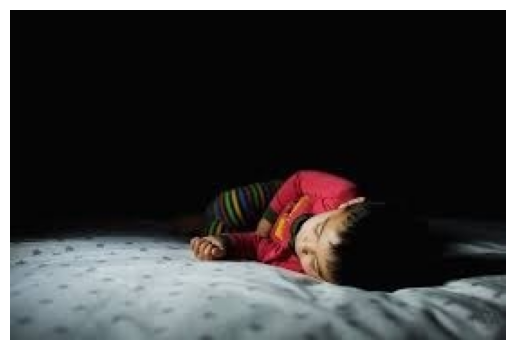

In [ ]:
# show matrix of a image with prompts score
def show_image_with_similarity(
    image,
    clip_classifier,
    image_processor=IMAGE_PROCESSOR,
    tokenizer=TOKENIZER,
    labels=CLASS_NAMES,
    top_k=7
):
    # get image embedding
    tensor_image = image_processor(image, return_tensors="pt")["pixel_values"].to(device)
    image_emb = clip_classifier.model.get_image_features(tensor_image)
    image_emb /= image_emb.norm(p=2, dim=-1, keepdim=True)

    # get labels embedding
    labels_emb = clip_classifier.generate_labels_embeddings(labels)

    # calculate similarity and get top-k results
    scores = torch.matmul(image_emb, labels_emb.T) # shape
    scores = torch.round(scores * 10000) / 10000
    top_k_scores, top_k_labels = scores.topk(top_k, dim=-1)

    # get scores, label dictionary
    scores_label_dict = {k: v for k, v in zip(top_k_scores.tolist()[0], [labels[i] for i in top_k_labels.tolist()[0]])}
    scores_label_dict = pd.DataFrame(scores_label_dict.items(), columns=['score', 'label'])
    scores_label_dict['prompt'] = [PROMPT.format(label=x) for x in scores_label_dict['label']]

    # display table and image
    display(scores_label_dict)
    plt.imshow(image); plt.axis('off'); plt.show()


index_sample = random.randint(0, len(test_dataset)); print(f"Sample index: {index_sample}")
show_image_with_similarity(test_dataset[index_sample]['image'], clip_classifier_before_finetune)


In [ ]:
del clip_baseline, clip_classifier
import gc; gc.collect()
torch.cuda.empty_cache()

# 3.Finetuning model

## 3.1.Define Trainer class

In [ ]:
@dataclass
class TraininingConfig:
    max_epochs: int = 15
    lr: float = 3e-6
    betas: Tuple[float, float] = (0.9, 0.995)
    num_warmup_steps: int = 3
    train_log_interval: int = 10
    val_log_interval: int = 10
    max_patience: int = 5
    output_dir: str = "checkpoints"
    batch_size: int = 256
    num_workers: int = 2

    def get(self, key, default=None):
        return getattr(self, key, default)

training_config = TraininingConfig(max_epochs=10, train_log_interval=10, val_log_interval=10, max_patience=5)

In [ ]:
class MyTrainer:
    def __init__(
        self,
        config: DictConfig,
        model: torch.nn.Module,
        train_dataset: Union[torch.utils.data.Dataset, datasets.Dataset],
        val_dataset: Union[torch.utils.data.Dataset, datasets.Dataset],
        tokenizer: CLIPTokenizerFast = TOKENIZER,
        labels: list[str] = CLASS_NAMES,
        optimizer: Optional[torch.optim.Optimizer] = None,
        scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
        logger: Optional[wandb.sdk.wandb_run.Run] = None,
        metrics_to_save_best: Optional[List[str]] = ["val/metrics/accuracy"],
        device: Optional[torch.device] = 'cuda',
        collate_fn: Optional[Callable] = collate_fn
    ):

        self.config = config
        self.device = device
        self._logger = logger
        self.setup_output_dir()
        # main components
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        # initialize some variables for training loop
        self.cur_step: int = -1
        self.cur_epoch: int = -1
        self.exit_by_patience: bool = False
        self.current_patience: int = -1
        self.max_patience: int = config.get("patience", math.inf)
        self.best_metrics_values: Dict[str, Any] = {
            **{key: -1 for key in metrics_to_save_best}
        }
        self.history_metrics: List[Dict[str, Any]] = []

        self.collate_fn = collate_fn
        self.tokenizer = tokenizer
        self.labels = labels
        self.build_dataloader(train_dataset)
        # self.setup_optimizers_before_training(config)
        print(self.config)


    def build_dataloader(self, dataset):
        self.train_dataloader = DataLoader(
            dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.num_workers,
            collate_fn=self.collate_fn,
        )
        self.val_dataloader = DataLoader(
            self.val_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.num_workers,
            collate_fn=self.collate_fn,
        )

    def setup_output_dir(self):
        self.project_name = self._logger.project
        self.group_name = self._logger.group
        self.experiment_name = self._logger.name
        if self._logger is None: return
        output_dir = self.config.get("output_dir", "checkpoints")
        prefix = (
            f"{output_dir}/{self.project_name}/{self.group_name}/{self.experiment_name}"
        )
        if not os.path.exists(prefix): os.makedirs(prefix)
        with open(f"{prefix}/config.yaml", "w") as f:
            OmegaConf.save(self.config, f)
        self.checkpoint_prefix = prefix

    def extract_loss(self, output, validation=False) -> torch.Tensor:
        if hasattr(output, "losses"):
            losses = output.losses
        elif isinstance(output, torch.Tensor):
            losses = {"total": output}
        else:
            losses = output
        total_loss = 0
        for key in losses:
            if losses[key] is not None:
                total_loss += losses[key]
                loss_reduce = losses[key].detach()
                if validation:
                    mode = "validation"
                else:
                    mode = "train"
                self.log(
                    f"{mode}/losses/{key}",
                    loss_reduce.item(),
                )
                # print(f"{mode}/losses/{key}", loss_reduce.item())
        return total_loss

    def train(self) -> None:
        self.setup_optimizers_before_training(self.config)
        model, optimizer, scheduler = (self.model, self.optimizer, self.scheduler)
        # model.to(self.device)
        pbar_train_dataloader = tqdm(self.train_dataloader, total=len(self.train_dataloader), desc="Training")
        # Below training loop use model (not self.model) and optimizer (not self.optimizer)
        while True:  # until meet max epoch or max patience
            self.cur_epoch += 1
            # dataloader = self.train_dataloader
            print(f"Epoch {self.cur_epoch}")
            pbar_train_dataloader.reset()
            for data in pbar_train_dataloader:
                self.cur_step += 1
                # CHECK EXIT CONDITION
                if (
                    self.cur_epoch >= self.config.max_epochs
                    or self.exit_by_patience == True
                ):
                    print("Exit requirement reached, exiting")
                    self.save_checkpoint(for_last=True)
                    return self.get_training_results()
                # FORWARD PASS
                model.train()
                data = self.move_to_device(data, self.device)
                optimizer.zero_grad(set_to_none=True)
                with torch.autocast(device_type=self.device, dtype=torch.bfloat16):
                    if type(data) is dict:
                        output = model(**data)
                    elif type(data) is list:
                        output = model(*data)
                    else:
                        output = model(data)

                    total_loss = self.extract_loss(output)
                # BACKWARD PASS
                total_loss.backward()
                optimizer.step()
                # LEARNING RATE MONITOR
                if self.cur_step % self.config.train_log_interval == 0:
                    for index_group in range(len(optimizer.param_groups)):
                        lr = optimizer.param_groups[index_group]["lr"]
                        self.log(f"train/lr_group_{index_group}", lr)
                    print("Learning rate: ", lr)
                    print("Total loss: ", total_loss)
                scheduler.step()
            self.on_validate_start()


    def move_to_device(self, obj, device):
        if isinstance(obj, dict):
            d = {}
            for k, v in obj.items():
                d[k] = self.move_to_device(v, device)
            return d
        if isinstance(obj, list):
            l = []
            for v in obj:
                l.append(self.move_to_device(v, device))
            return l
        return obj.to(device)

    def on_validate_start(self):
        metrics_dict = self.validate()
        self.handle_checkpoint_with_patience(metrics_dict, set_patience=True)
        self.setup_for_patience_callback()
        torch.cuda.empty_cache()

    def validate(self):
        validation_loader = self.val_dataloader
        model = self.model

        model.eval()
        print("Evaluating")
        with torch.no_grad():
            metrics = self.evaluate(validation_loader)
            if metrics is not None:
                history_obj = {}
                for key in metrics:
                    log_key = f"val/metrics/{key}"
                    self.log(
                        log_key,
                        metrics[key],
                    )
                    history_obj[key] = round(metrics[key], 4)
                    print(f"{key}: {metrics[key]}")
                self.history_metrics.append(
                    {**history_obj, "epoch": self.cur_epoch, "step": self.cur_step}
                )
        return metrics

    @torch.no_grad()
    def evaluate(self, dataloader):
        results_dict = evaluate_clip_classifier(
            self.model,
            self.val_dataset,
            self.tokenizer,
            self.labels,
            batch_size=self.config.batch_size,
            num_workers=self.config.num_workers,
            device=self.device,
        )
        return results_dict

    def setup_for_patience_callback(self):
        if self.current_patience > self.max_patience:
            print("Early stopping")
            self.exit_by_patience = True

    def handle_checkpoint_with_patience(
        self, metrics: Dict[str, Any], set_patience=True
    ):
        reset_patience_flag = False
        if len(self.best_metrics_values) == 0:
            self.best_metrics_values = metrics
            return
        for key in self.best_metrics_values:
            short_key = key.split("/")[-1]
            if metrics.get(short_key, -100) > self.best_metrics_values[key]:
                self.best_metrics_values[key] = metrics[short_key]
                self.save_checkpoint(name=f"best_{short_key}")
                reset_patience_flag = True
        if set_patience:
            if reset_patience_flag:
                self.current_patience = 0
            else:
                self.current_patience += 1

    def save_checkpoint(self, name="last", for_last=False):
        model_no_ddp = self.model
        check_point_file_path = (
            f"{self.checkpoint_prefix}/{name}.pt"
            if not for_last
            else f"{self.checkpoint_prefix}/last.pt"
        )
        model_state_dict = model_no_ddp.state_dict()
        save_obj = {
            "model": model_state_dict,
            "optimizer": self.optimizer.state_dict(),
            "scheduler": self.scheduler.state_dict(),
            "config": self.config,
            "epoch": self.cur_epoch,
            "history": self.history_metrics,
            "best_metrics": self.best_metrics_values,
            "patience": self.current_patience,
        }
        torch.save(
            save_obj,
            check_point_file_path,
        )
        torch.cuda.empty_cache()

    def log(
        self,
        name: str,
        value: Union[torch.Tensor, float, int],
    ):
        if type(self._logger) is not None:
            self._logger.log(
                {name: value, "epoch": self.cur_epoch}, step=self.cur_step
            )

    def setup_optimizers_before_training(self, config):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=config.get("lr", 1e-4),
            betas=config.get("betas", (0.9, 0.995)),
        )
        self.scheduler = transformers.get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=config.get("num_warmup_steps", 100),
            num_training_steps=config.get("max_epochs", 10) * len(self.train_dataloader),
            num_cycles=config.get("num_cycles", 0.5),
            last_epoch=self.cur_epoch,
        )

    def get_training_results(self):
        history_metrics = pd.DataFrame(self.history_metrics).round(4)
        return {
            "history": history_metrics,
            "best_metrics": self.best_metrics_values,
            "patience": self.current_patience,
        }

## 3.2.Training

- Create Logger
    - An window will be opened to create a new logger that require an input number.
    - Please input 1 for initializing logger without login (anonymous logger).

In [ ]:
# wandb.login()
time_str = str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S-"))
logger = wandb.init(
    anonymous="allow",
    project="<finetune><clip><har_dataset>",
    group="finetune_har_dataset",
    name=time_str +"-finetune_clip",
    config=training_config,
    notes="",
    tags=['<finetune>', '<clip>', '<har>'],
)

wandb: Currently logged in as: anony-mouse-505045176506006198. Use `wandb login --relogin` to force relogin


In [ ]:
clip_model_for_finetuning = CLIPModel.from_pretrained(MODEL_NAME)
clip_classifier = CLIPLabelRetriever(clip_model_for_finetuning, TOKENIZER, CLASS_NAMES).to('cuda')
trainer = MyTrainer(
    config=training_config,
    model=clip_classifier,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    logger=logger,
    device='cuda'
)

TraininingConfig(max_epochs=10, lr=3e-06, betas=(0.9, 0.995), num_warmup_steps=3, train_log_interval=10, val_log_interval=10, max_patience=5, output_dir='checkpoints', batch_size=256, num_workers=2)


In [ ]:
training_results = trainer.train()

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Training:   3%|▎         | 1/30 [00:02<01:12,  2.51s/it]

Learning rate:  0.0
Total loss:  tensor(0.6379, device='cuda:0', grad_fn=<AddBackward0>)


Training:  37%|███▋      | 11/30 [00:08<00:13,  1.41it/s]

Learning rate:  2.995889962722784e-06
Total loss:  tensor(0.3254, device='cuda:0', grad_fn=<AddBackward0>)


Training:  70%|███████   | 21/30 [00:15<00:06,  1.40it/s]

Learning rate:  2.975813369893649e-06
Total loss:  tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)


Training: 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Evaluate metrics: {'accuracy': 0.9185185185185185, 'f1': 0.9180712779219391, 'precision': 0.9183889161700223, 'recall': 0.9185185185185187}
accuracy: 0.9185185185185185
f1: 0.9180712779219391
precision: 0.9183889161700223
recall: 0.9185185185185187
Epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Learning rate:  2.9392394604217463e-06
Total loss:  tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  2.8865770741900383e-06
Total loss:  tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  2.8184148954309296e-06
Total loss:  tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)
Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Evaluate metrics: {'accuracy': 0.9227513227513228, 'f1': 0.9226645238887335, 'precision': 0.9232979383540567, 'recall': 0.9227513227513229}
accuracy: 0.9227513227513228
f1: 0.9226645238887335
precision: 0.9232979383540567
recall: 0.9227513227513229
Epoch 2


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Learning rate:  2.735514872144749e-06
Total loss:  tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  2.638803698696615e-06
Total loss:  tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  2.529362456803101e-06
Total loss:  tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)
Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Evaluate metrics: {'accuracy': 0.9232804232804233, 'f1': 0.9228945503851204, 'precision': 0.9231215124271185, 'recall': 0.9232804232804235}
accuracy: 0.9232804232804233
f1: 0.9228945503851204
precision: 0.9231215124271185
recall: 0.9232804232804235
Epoch 3


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Learning rate:  2.4084145307065e-06
Total loss:  tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  2.277311931626393e-06
Total loss:  tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  2.137520184360045e-06
Total loss:  tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)
Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Evaluate metrics: {'accuracy': 0.9259259259259259, 'f1': 0.9258484280746021, 'precision': 0.9261247093251898, 'recall': 0.925925925925926}
accuracy: 0.9259259259259259
f1: 0.9258484280746021
precision: 0.9261247093251898
recall: 0.925925925925926
Epoch 4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Learning rate:  1.990601944976133e-06
Total loss:  tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  1.8381995327307068e-06
Total loss:  tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  1.6820165714716229e-06
Total loss:  tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Evaluate metrics: {'accuracy': 0.9238095238095239, 'f1': 0.9235226024866698, 'precision': 0.9237347476653422, 'recall': 0.923809523809524}
accuracy: 0.9238095238095239
f1: 0.9235226024866698
precision: 0.9237347476653422
recall: 0.923809523809524
Epoch 5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Learning rate:  1.523798945752212e-06
Total loss:  tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  1.3653152845354625e-06
Total loss:  tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  1.2083371906507938e-06
Total loss:  tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Evaluate metrics: {'accuracy': 0.9232804232804233, 'f1': 0.9228593605706829, 'precision': 0.9230210604631057, 'recall': 0.9232804232804235}
accuracy: 0.9232804232804233
f1: 0.9228593605706829
precision: 0.9230210604631057
recall: 0.9232804232804235
Epoch 6


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Learning rate:  1.0546194370075883e-06
Total loss:  tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  9.058803509412648e-07
Total loss:  tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  7.637826059646481e-07
Total loss:  tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Evaluate metrics: {'accuracy': 0.9248677248677248, 'f1': 0.9244281570947285, 'precision': 0.924538756003521, 'recall': 0.9248677248677251}
accuracy: 0.9248677248677248
f1: 0.9244281570947285
precision: 0.924538756003521
recall: 0.9248677248677251
Epoch 7


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Learning rate:  6.29914635643203e-07
Total loss:  tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  5.05772877358356e-07
Total loss:  tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  3.9274504444622023e-07
Total loss:  tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Evaluate metrics: {'accuracy': 0.9238095238095239, 'f1': 0.9234823873438384, 'precision': 0.9235757292434523, 'recall': 0.923809523809524}
accuracy: 0.9238095238095239
f1: 0.9234823873438384
precision: 0.9235757292434523
recall: 0.923809523809524
Epoch 8


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Learning rate:  2.920946137034121e-07
Total loss:  tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  2.0494670166571354e-07
Total loss:  tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  1.322754875409915e-07
Total loss:  tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Evaluate metrics: {'accuracy': 0.9243386243386243, 'f1': 0.9239566446670167, 'precision': 0.9240439216129506, 'recall': 0.9243386243386245}
accuracy: 0.9243386243386243
f1: 0.9239566446670167
precision: 0.9240439216129506
recall: 0.9243386243386245
Epoch 9


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Learning rate:  7.489332338858202e-08
Total loss:  tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  3.344165327653725e-08
Total loss:  tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
Learning rate:  8.383842926539932e-09
Total loss:  tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Evaluating


Evaluate model on dataset: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Evaluate metrics: {'accuracy': 0.9248677248677248, 'f1': 0.9245325854300165, 'precision': 0.9246261141139496, 'recall': 0.9248677248677251}
accuracy: 0.9248677248677248
f1: 0.9245325854300165
precision: 0.9246261141139496
recall: 0.9248677248677251
Epoch 10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Exit requirement reached, exiting


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [ ]:
training_results['best_metrics']

{'val/metrics/accuracy': 0.9259259259259259}

In [ ]:
training_results['patience']

6

- The training was stopped after 10 epochs due to the max patience = 5.
The metrics considered for early stopping is the accuracy
.

In [ ]:
training_results['history']

,accuracy,f1,precision,recall,epoch,step
0,0.9185,0.9181,0.9184,0.9185,0,29
1,0.9228,0.9227,0.9233,0.9228,1,59
2,0.9233,0.9229,0.9231,0.9233,2,89
3,0.9259,0.9258,0.9261,0.9259,3,119
4,0.9238,0.9235,0.9237,0.9238,4,149
5,0.9233,0.9229,0.9230,0.9233,5,179
6,0.9249,0.9244,0.9245,0.9249,6,209
7,0.9238,0.9235,0.9236,0.9238,7,239
8,0.9243,0.9240,0.9240,0.9243,8,269
9,0.9249,0.9245,0.9246,0.9249,9,299


# 4.Evaluation model

## 4.1.Evaluate model on test set

In [ ]:
test_result = evaluate_clip_classifier(
    clip_classifier,
    test_dataset,
    TOKENIZER,
    CLASS_NAMES,
    batch_size=training_config.batch_size,
    num_workers=training_config.num_workers,
    device='cuda'
)

Evaluate model on dataset:   0%|          | 0/13 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Evaluate model on dataset: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Evaluate metrics: {'accuracy': 0.919047619047619, 'f1': 0.9194084454746646, 'precision': 0.9204551787533334, 'recall': 0.9190476190476192}


Before finetuning, the CLIP model has achieved these result

In [ ]:
test_result

{'accuracy': 0.919047619047619,
 'f1': 0.9194084454746646,
 'precision': 0.9204551787533334,
 'recall': 0.9190476190476192}

In [ ]:
serie = pd.Series(test_result, name="Metric Values After Finetuning").round(4)
display(serie.to_frame())

,Metric Values After Finetuning
accuracy,0.9190
f1,0.9194
precision,0.9205
recall,0.9190


In [ ]:
# combine the two series
comparison = pd.concat([temp_serie, serie], axis=1)
comparison

,Metric Values Before Finetuning,Metric Values After Finetuning
accuracy,0.8156,0.9190
f1,0.8128,0.9194
precision,0.8341,0.9205
recall,0.8156,0.9190


## 4.2.Confusion Matrix


In [ ]:
#  Reload the best model if out of CUDA memory
# model_path = '/content/checkpoints/<finetune><clip><har_dataset>/finetune_har_dataset/2024-06-16_09-56-33--finetune_clip/best_accuracy.pt'
# clip_model_for_finetuning = CLIPModel.from_pretrained(MODEL_NAME)
# clip_classifier = CLIPLabelRetriever(clip_model_for_finetuning, TOKENIZER, CLASS_NAMES).to('cuda')
# clip_classifier.load_state_dict(torch.load(model_path)['model'])

<All keys matched successfully>

In [ ]:
def get_predictions(model, test_dataset, collate_fn=collate_fn):
    """Function calculates accuracy of given model on dataloader

    Args:
        model (CLIPClassifier): CLIP classifier model
        test_dataset (torch.utils.data.Dataset): test dataset
        config (DictConfig): config

    Returns:
        predictions (torch.Tensor): model predictions
        references (torch.Tensor): model references
        confusion_matrix (torch.Tensor): confusion matrix
    """
    dataloader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn,
    )
    predictions_list = []
    references_list = []
    device = get_module_device(model)
    for batch in tqdm(
        dataloader, total=len(dataloader), desc="Evaluate model on dataset"
    ):
        batch["pixel_values"] = batch["pixel_values"].to(device)
        predictions = model(**batch, return_loss=False)
        predictions_list.append(torch.argmax(predictions, dim=1))
        references_list.append(batch["label_id"])

    predictions = torch.cat(predictions_list)
    references = torch.cat(references_list)
    confusion_matrix = sklearn.metrics.confusion_matrix(
        references.cpu().numpy(), predictions.cpu().numpy()
    )

    return {
        "predictions": predictions,
        "references": references,
        "confusion_matrix": confusion_matrix,
    }

In [ ]:
predict_results = get_predictions(clip_classifier, test_dataset)

Evaluate model on dataset:   0%|          | 0/50 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Evaluate model on dataset: 100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


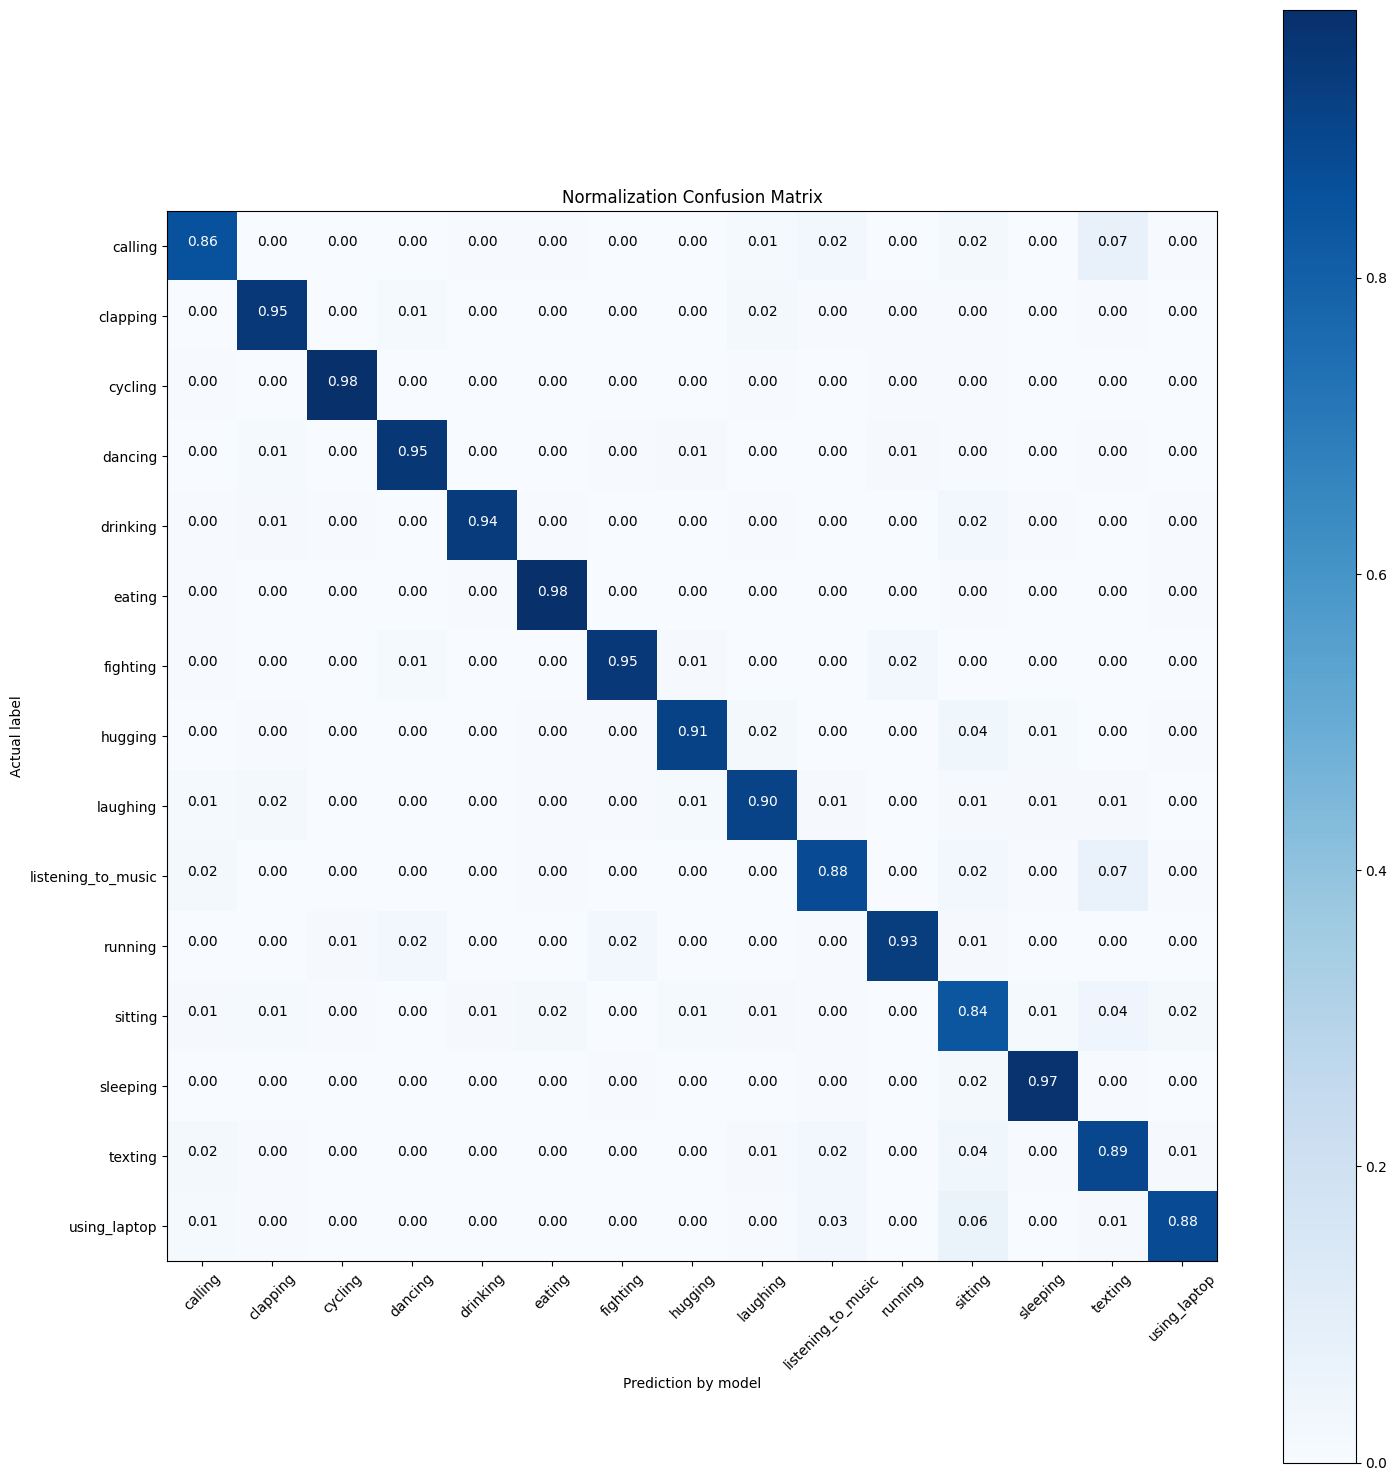

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.figure(figsize = (15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    import itertools
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Prediction by model')
    plt.tight_layout()

cnf_matrix = predict_results['confusion_matrix']
np.set_printoptions(precision = 3)
plot_confusion_matrix(cnf_matrix, classes=CLASS_NAMES, title='Normalization Confusion Matrix')
plt.show()


Sample index: 2683


,score,label,prompt
0,0.3263,texting,a photo of person/people who is/are texting
1,0.2815,eating,a photo of person/people who is/are eating
2,0.2570,listening_to_music,a photo of person/people who is/are listening_...
3,0.2521,drinking,a photo of person/people who is/are drinking
4,0.2473,sitting,a photo of person/people who is/are sitting
5,0.2405,calling,a photo of person/people who is/are calling
6,0.2200,sleeping,a photo of person/people who is/are sleeping


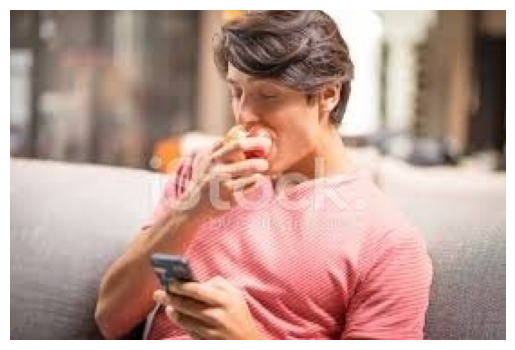

In [ ]:
# show matrix of a image with prompts score
def show_image_with_similarity(
    image,
    clip_classifier,
    image_processor=IMAGE_PROCESSOR,
    tokenizer=TOKENIZER,
    labels=CLASS_NAMES,
    top_k=7
):
    # get image embedding
    tensor_image = image_processor(image, return_tensors="pt")["pixel_values"].to(device)
    image_emb = clip_classifier.model.get_image_features(tensor_image)
    image_emb /= image_emb.norm(p=2, dim=-1, keepdim=True)

    # get labels embedding
    labels_emb = clip_classifier.generate_labels_embeddings(labels)

    # calculate similarity and get top-k results
    scores = torch.matmul(image_emb, labels_emb.T) # shape
    scores = torch.round(scores * 10000) / 10000
    top_k_scores, top_k_labels = scores.topk(top_k, dim=-1)

    # get scores, label dictionary
    scores_label_dict = {k: v for k, v in zip(top_k_scores.tolist()[0], [labels[i] for i in top_k_labels.tolist()[0]])}
    scores_label_dict = pd.DataFrame(scores_label_dict.items(), columns=['score', 'label'])
    scores_label_dict['prompt'] = [PROMPT.format(label=x) for x in scores_label_dict['label']]

    # display table and image
    display(scores_label_dict)
    plt.imshow(image); plt.axis('off'); plt.show()

index_sample = random.randint(0, len(test_dataset)); print(f"Sample index: {index_sample}")
show_image_with_similarity(test_dataset[index_sample]['image'], clip_classifier)